# Part 3
Make the figures for Spatial Phase variation qualitative images


In [3]:
from matplotlib import pyplot as plt
import numpy as np
import math
import os
import numpy as np

import sigpy as sp
import sigpy.plot as pl
import seaborn as sns
from cmcrameri import cm

from dipy.segment.mask import median_otsu
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs
import numpy as np
import nrrd
import pingouin as pg
import scikit_posthocs as sp

from scipy.signal import argrelextrema

import sys
sys.path.append("/Users/arielhannum/Documents/Stanford/CMR-Setsompop/Code/cDTI_python")
from mystic_mrpy.Data_Import.Diffusion   import *
from mystic_mrpy.Data_Sorting.Diffusion  import *
from mystic_mrpy.Diffusion.DWI  import *
from mystic_mrpy.Diffusion.Gibbs         import *
from mystic_mrpy.Diffusion.Registration  import *
from mystic_mrpy.Diffusion.Rejection     import *
from mystic_mrpy.Diffusion.Respiratory   import *
from mystic_mrpy.Diffusion.Averaging     import *
from mystic_mrpy.Diffusion.Denoising     import *
from mystic_mrpy.Diffusion.Interpolation import *
from mystic_mrpy.Diffusion.Segmentation_Matrix_DTI import *
from mystic_mrpy.Diffusion.DTI import *
from mystic_mrpy.Diffusion.cDTI import *

import numpy as np
import matplotlib.pyplot as plt

/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [4]:
from PIL import Image, ImageFilter
def get_edge(img):
    #define the vertical filter
    vertical_filter = [[-1,-2,-1], [0,0,0], [1,2,1]]

    #define the horizontal filter
    horizontal_filter = [[-1,0,1], [-2,0,2], [-1,0,1]]

    #get the dimensions of the image
    n,m = img.shape

    #initialize the edges image
    edges_img = img.copy()

    #loop over all pixels in the image
    for row in range(3, n-2):
        for col in range(3, m-2):

            #create little local 3x3 box
            local_pixels = img[row-1:row+2, col-1:col+2]

            #apply the vertical filter
            vertical_transformed_pixels = vertical_filter*local_pixels
            #remap the vertical score
            vertical_score = vertical_transformed_pixels.sum()/4

            #apply the horizontal filter
            horizontal_transformed_pixels = horizontal_filter*local_pixels
            #remap the horizontal score
            horizontal_score = horizontal_transformed_pixels.sum()/4

            #combine the horizontal and vertical scores into a total edge score
            edge_score = (vertical_score**2 + horizontal_score**2)**.5

            #insert this edge score into the edges image
            edges_img[row, col] = edge_score*2

    #remap the values in the 0-1 range in case they went out of bounds
    edges_img = edges_img/edges_img.max()
    edges_img[edges_img>0] = 1
    edges_img.dtype = float
    edges_img[edges_img ==0] = 'nan'
    return edges_img

In [5]:
# Load in Spatial Gradients


vv = 5 # volunteer
diffusion = -1 # diffusion direction [0, X [1], Y[2], Z[3]]
sl = 3 #slice [Base [0], Mid[0], Apex[2]]
rep = 1
volunteers=[1,2,3,4,5,7,8,9,10,11]
slope_m0 = np.zeros((128, 128, 6, 4, 5, 8))
slope_m1 = np.zeros((128, 128, 6, 4, 5, 8))
slope_m2 = np.zeros((128, 128, 6, 4, 5, 8))


volunteer = str(volunteers[vv])
inpath = '/Users/arielhannum/Documents/Stanford/CMR-Setsompop/Projects/Phase/Data/Brain/V00' + volunteer + '/3_DWI/'
savename = os.path.join(inpath,'M0_slope.npy')
slope_m0 = np.load(savename)

savename = os.path.join(inpath,'M1_slope.npy')
slope_m1 = np.load(savename)

savename = os.path.join(inpath,'M2_slope.npy')
slope_m2 = np.load(savename)

    

In [6]:
# Load in Mask

volunteers=[1,2,3,4,5,7,8,9,10,11]
import cv2
volunteer = str(volunteers[vv])
print(volunteer, end = ' ')
inpath = '/Users/arielhannum/Documents/Stanford/CMR-Setsompop/Projects/Phase/Data/Brain/V00' + volunteer + '/3_DWI/'
name = inpath.split('/')
namejoin = '/'.join(name[:-1])

num = 0
for num in range(3):
    mask_end   = [_ for _ in os.listdir(inpath) if _.endswith('new.nrrd')]
    mask_end.sort()
    mask_end,header =  nrrd.read(os.path.join(inpath, mask_end[num]))
    mask = mask_end
    mask = mask.astype('float')
    mask[mask==0] = np.nan


    nii_files   = [_ for _ in os.listdir(inpath) if _.endswith('registered.nii')]
    bval_files   = [_ for _ in os.listdir(inpath) if _.endswith('registered.bvals')]
    bvec_files   = [_ for _ in os.listdir(inpath) if _.endswith('registered.bvecs')]

    nii_files.sort()
    bval_files.sort()
    bvec_files.sort()

    data,affine, voxsize = load_nifti(os.path.join(inpath, nii_files[num]), return_voxsize=True)
    bvals = np.loadtxt(os.path.join(inpath,bval_files[num])) 
    bvecs = np.loadtxt(os.path.join(inpath,bvec_files[num]))

    data1,bvals_sort,bvecs_sort = stacked2sorted(data,bvals,bvecs.T)
    ims = np.stack((data1[:,:,:,:,:5],data1[:,:,:,:,5:10],data1[:,:,:,:,10:15],
                        data1[:,:,:,:,15:20],data1[:,:,:,:,20:25],data1[:,:,:,:,25:30],
                        data1[:,:,:,:,30:35],data1[:,:,:,:,35:40]),axis = -1)  
    mag = abs(ims)
    phs = np.angle(ims)

    if num ==0:
        M0_mask_new = mask
        M0_phs = phs
        M0_mag = mag #* mask_rep
    if num ==1:
        M1_mask_new = mask
        M1_phs = phs
        M1_mag = mag #* mask_rep
    if num ==2:
        M2_mask_new = mask
        M2_phs = phs
        M2_mag = mag #* mask_rep



7 

In [7]:
# Calculate STD
M0_adj = slope_m0
M1_adj = slope_m1
M2_adj = slope_m2

M0_diff = M0_adj - np.nanmean(M0_adj,axis = -2)[:,:,:,:,np.newaxis,:]
M1_diff= M1_adj - np.nanmean(M1_adj,axis = -2)[:,:,:,:,np.newaxis,:]
M2_diff= M2_adj - np.nanmean(M2_adj,axis = -2)[:,:,:,:,np.newaxis,:]

M0_std = np.nanstd(slope_m0,axis = -2)#np.sqrt(np.sum((M0_diff)**2,axis = -2)/5)
M1_std = np.nanstd(slope_m1,axis = -2)#np.sqrt(np.sum((M1_diff)**2,axis = -2)/5)
M2_std = np.nanstd(slope_m2,axis = -2)#np.sqrt(np.sum((M2_diff)**2,axis = -2)/5)

<ipython-input-7-38a0e0b520f4>:6: RuntimeWarning: Mean of empty slice
  M0_diff = M0_adj - np.nanmean(M0_adj,axis = -2)[:,:,:,:,np.newaxis,:]
<ipython-input-7-38a0e0b520f4>:7: RuntimeWarning: Mean of empty slice
  M1_diff= M1_adj - np.nanmean(M1_adj,axis = -2)[:,:,:,:,np.newaxis,:]
<ipython-input-7-38a0e0b520f4>:8: RuntimeWarning: Mean of empty slice
  M2_diff= M2_adj - np.nanmean(M2_adj,axis = -2)[:,:,:,:,np.newaxis,:]
/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [8]:
slope_m0.dtype

dtype('float64')

## Use 1 Volunteer for figure

In [9]:
slope_m0 = np.zeros((128, 128, 6, 4, 5, 8))
slope_m1 = np.zeros((128, 128, 6, 4, 5, 8))
slope_m2 = np.zeros((128, 128, 6, 4, 5, 8))


volunteer = str(volunteers[vv])
inpath = '/Users/arielhannum/Documents/Stanford/CMR-Setsompop/Projects/Phase/Data/Brain/V00' + volunteer + '/3_DWI/'
savename = os.path.join(inpath,'M0_slope.npy')
slope_m0 = np.load(savename)

savename = os.path.join(inpath,'M1_slope.npy')
slope_m1 = np.load(savename)

savename = os.path.join(inpath,'M2_slope.npy')
slope_m2 = np.load(savename)

TD 0 Volunteer 5 sl 1


<ipython-input-14-865c55d2339a>:21: RuntimeWarning: Mean of empty slice
  phs_m0 = np.nanmean(slope_m0,axis = -2)[:,:,:,:,np.newaxis,:] * M0_mask_new[:,:,:,np.newaxis,np.newaxis,np.newaxis]
<ipython-input-14-865c55d2339a>:22: RuntimeWarning: Mean of empty slice
  phs_m1 = np.nanmean(slope_m1,axis = -2)[:,:,:,:,np.newaxis,:] * M1_mask_new[:,:,:,np.newaxis,np.newaxis,np.newaxis]
<ipython-input-14-865c55d2339a>:23: RuntimeWarning: Mean of empty slice
  phs_m2 = np.nanmean(slope_m2,axis = -2)[:,:,:,:,np.newaxis,:] * M2_mask_new[:,:,:,np.newaxis,np.newaxis,np.newaxis]


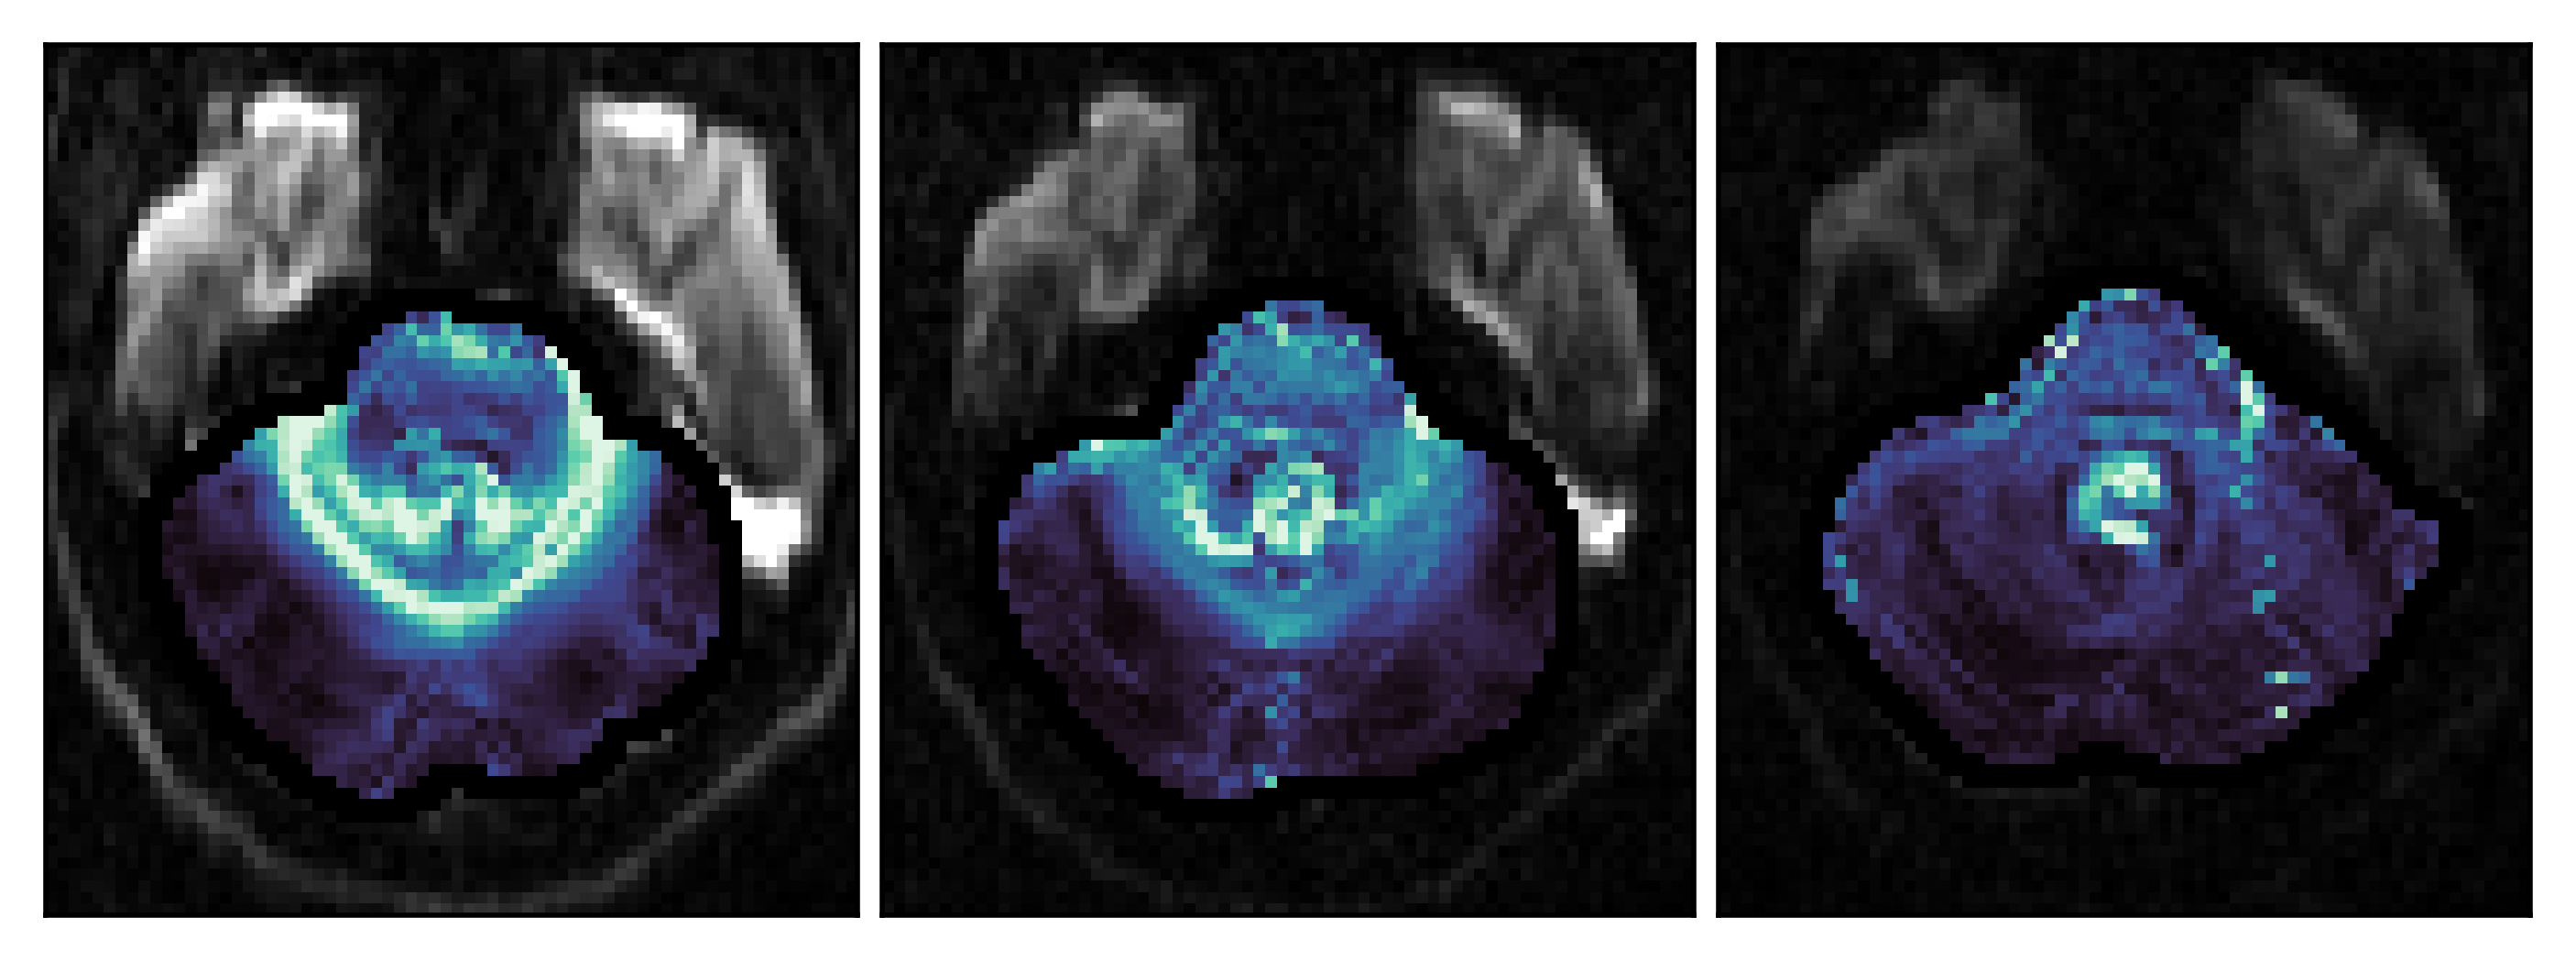

TD 3 Volunteer 5 sl 1


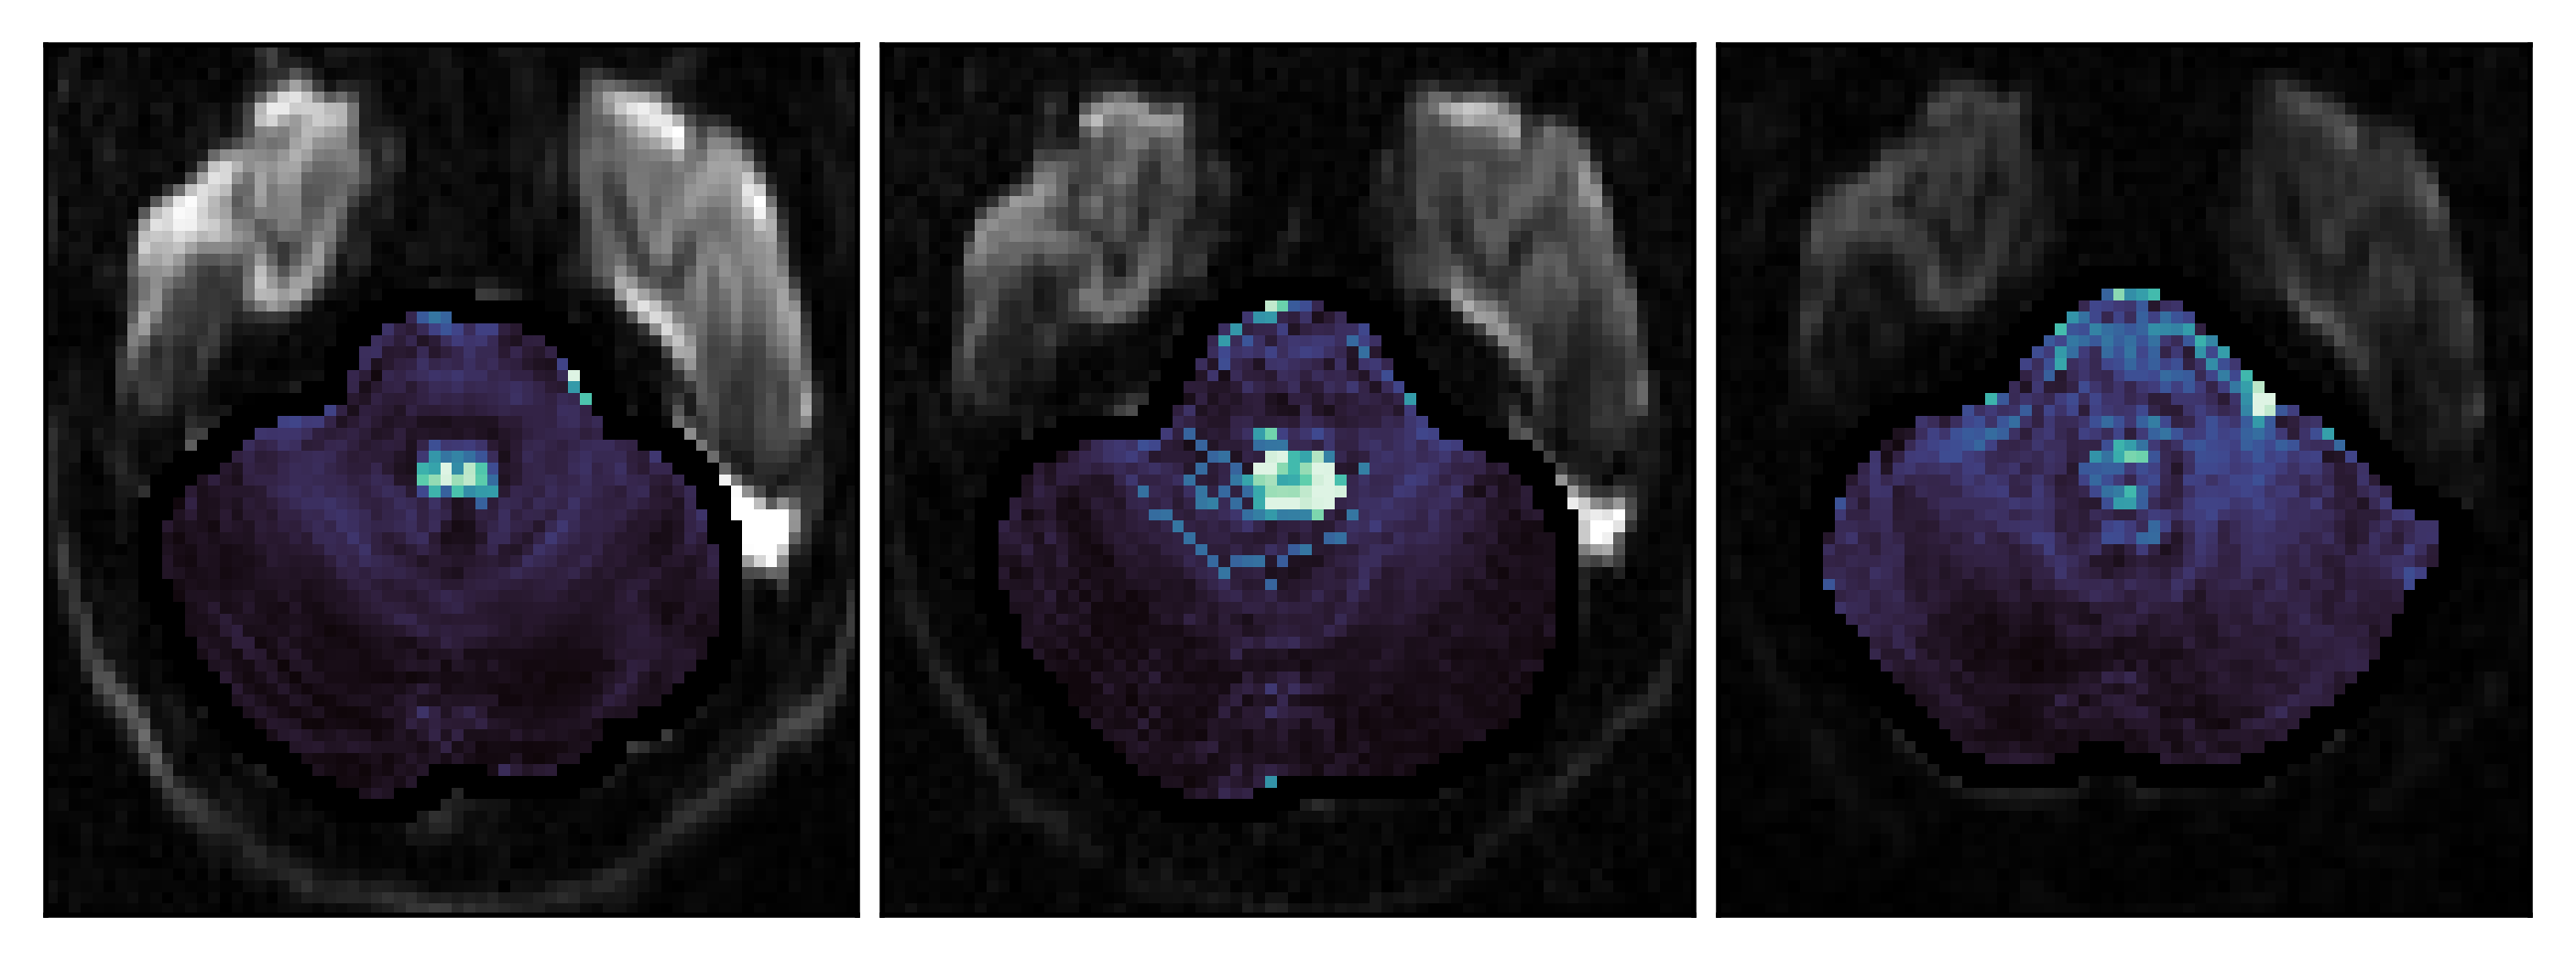

TD 6 Volunteer 5 sl 1


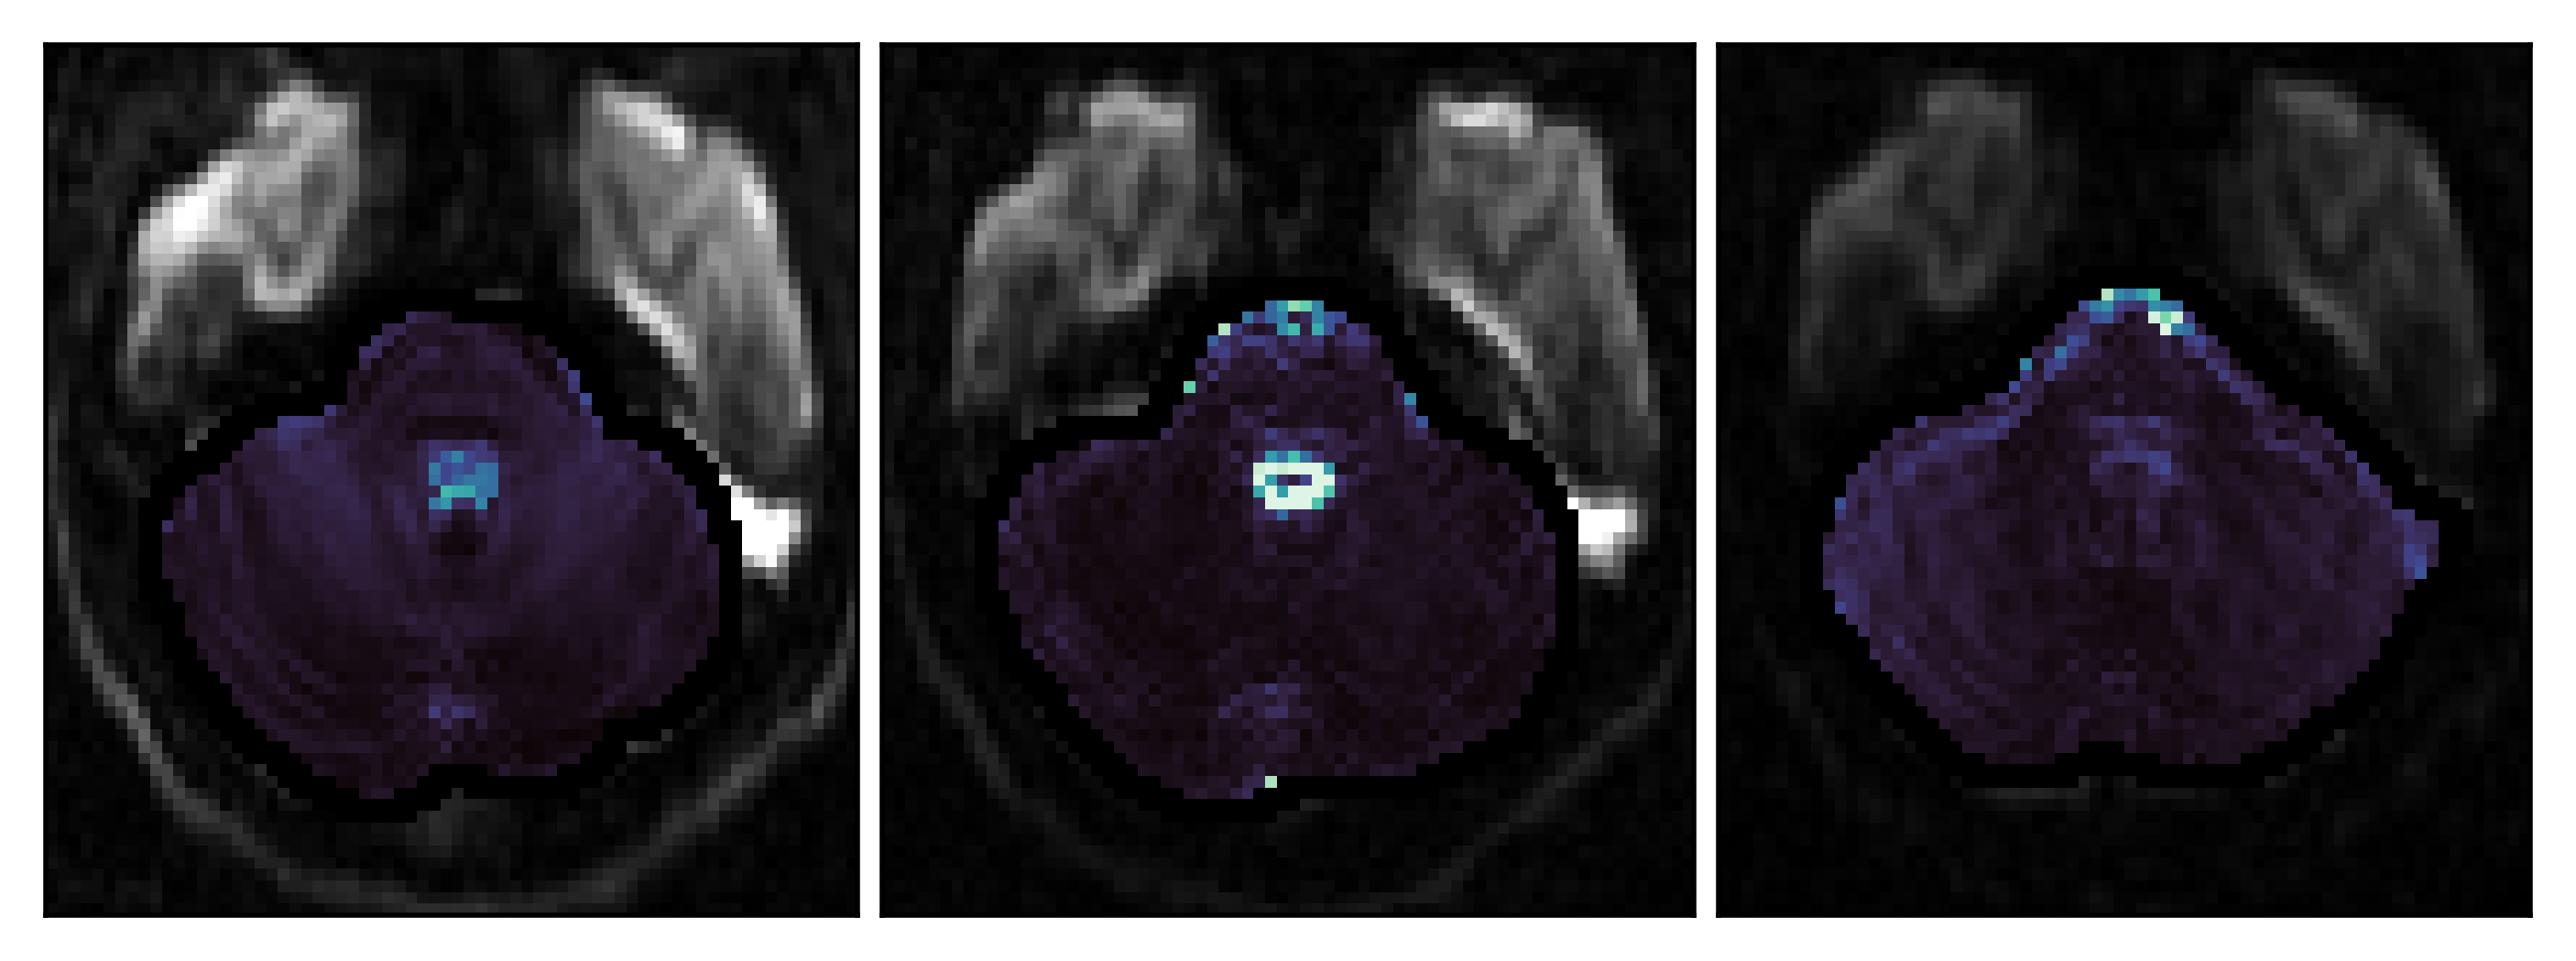

In [14]:
sl = 1
# Horizontal Fig 

for td in [0,3,6]:
    print('TD',td, 'Volunteer',vv,'sl',sl)
    fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(7,5), dpi=500)

    w1 = 35
    w2 = 110
    l1= 30
    l2 = 100

    ### Get magnitude images
    for ii in range(1):
        axes[0].imshow(abs(M0_mag)[w1:w2,l1:l2,sl,diffusion,rep,td],vmin = 0,vmax = 400,cmap = 'gray',interpolation = 'nearest')
        axes[1].imshow(abs(M1_mag)[w1:w2,l1:l2,sl,diffusion,rep,td],vmin = 0,vmax = 400,cmap = 'gray',interpolation = 'nearest')
        im0=axes[2].imshow(abs(M2_mag)[w1:w2,l1:l2,sl,diffusion,rep,td],vmin = 0,vmax = 400,cmap = 'gray',interpolation = 'nearest')

    color = sns.color_palette("mako",as_cmap = True)
    ######### Difference from Mean Phase
    phs_m0 = np.nanmean(slope_m0,axis = -2)[:,:,:,:,np.newaxis,:] * M0_mask_new[:,:,:,np.newaxis,np.newaxis,np.newaxis]
    phs_m1 = np.nanmean(slope_m1,axis = -2)[:,:,:,:,np.newaxis,:] * M1_mask_new[:,:,:,np.newaxis,np.newaxis,np.newaxis]
    phs_m2 = np.nanmean(slope_m2,axis = -2)[:,:,:,:,np.newaxis,:] * M2_mask_new[:,:,:,np.newaxis,np.newaxis,np.newaxis]
    axes[0].imshow(phs_m0[w1:w2,l1:l2,sl,diffusion,0,td],vmin = 0,vmax = math.pi/2,cmap = color,interpolation = 'nearest')
    axes[1].imshow(phs_m1[w1:w2,l1:l2,sl,diffusion,0,td],vmin = 0,vmax = math.pi/2,cmap = color,interpolation = 'nearest')
    im4=axes[2].imshow(phs_m2[w1:w2,l1:l2,sl,diffusion,0,td],vmin = 0,vmax = math.pi/2,cmap = color,interpolation = 'nearest')
    axes[0].imshow(get_edge(np.nan_to_num(M0_mask_new[w1:w2,l1:l2,sl,])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')
    axes[1].imshow(get_edge(np.nan_to_num(M1_mask_new[w1:w2,l1:l2,sl,])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')
    axes[2].imshow(get_edge(np.nan_to_num(M2_mask_new[w1:w2,l1:l2,sl,])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')


    """
    ######### STandard Deviation 
    color = cm.lajolla_r
    phs_m0 = (M0_std[:,:,:,:,np.newaxis,:]) * M0_mask_new[:,:,:,np.newaxis,np.newaxis,np.newaxis]
    phs_m1 = (M1_std[:,:,:,:,np.newaxis,:]) * M1_mask_new[:,:,:,np.newaxis,np.newaxis,np.newaxis]
    phs_m2 = (M2_std[:,:,:,:,np.newaxis,:]) * M2_mask_new[:,:,:,np.newaxis,np.newaxis,np.newaxis]
    axes[1,0].imshow(phs_m0[w1:w2,l1:l2,sl,diffusion,0,td],vmin = 0,vmax = math.pi/3,cmap = color,interpolation = 'nearest')
    axes[1,1].imshow(phs_m1[w1:w2,l1:l2,sl,diffusion,0,td],vmin = 0,vmax = math.pi/3,cmap = color,interpolation = 'nearest')
    im4=axes[1,2].imshow(phs_m2[w1:w2,l1:l2,sl,diffusion,0,td],vmin = 0,vmax = math.pi/3,cmap = color,interpolation = 'nearest')
    axes[1,0].imshow(get_edge(np.nan_to_num(M0_mask_new[w1:w2,l1:l2,sl,])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')
    axes[1,1].imshow(get_edge(np.nan_to_num(M1_mask_new[w1:w2,l1:l2,sl,])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')
    axes[1,2].imshow(get_edge(np.nan_to_num(M2_mask_new[w1:w2,l1:l2,sl,])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')
    """
    #for m in range(2):
    for j in range(3):
        axes[j].get_xaxis().set_ticks([])
        axes[j].get_yaxis().set_ticks([])
    

    plt.subplots_adjust(wspace=0.03, hspace=0.03)  
    plt.show()

TD 6 Volunteer 5 sl 1


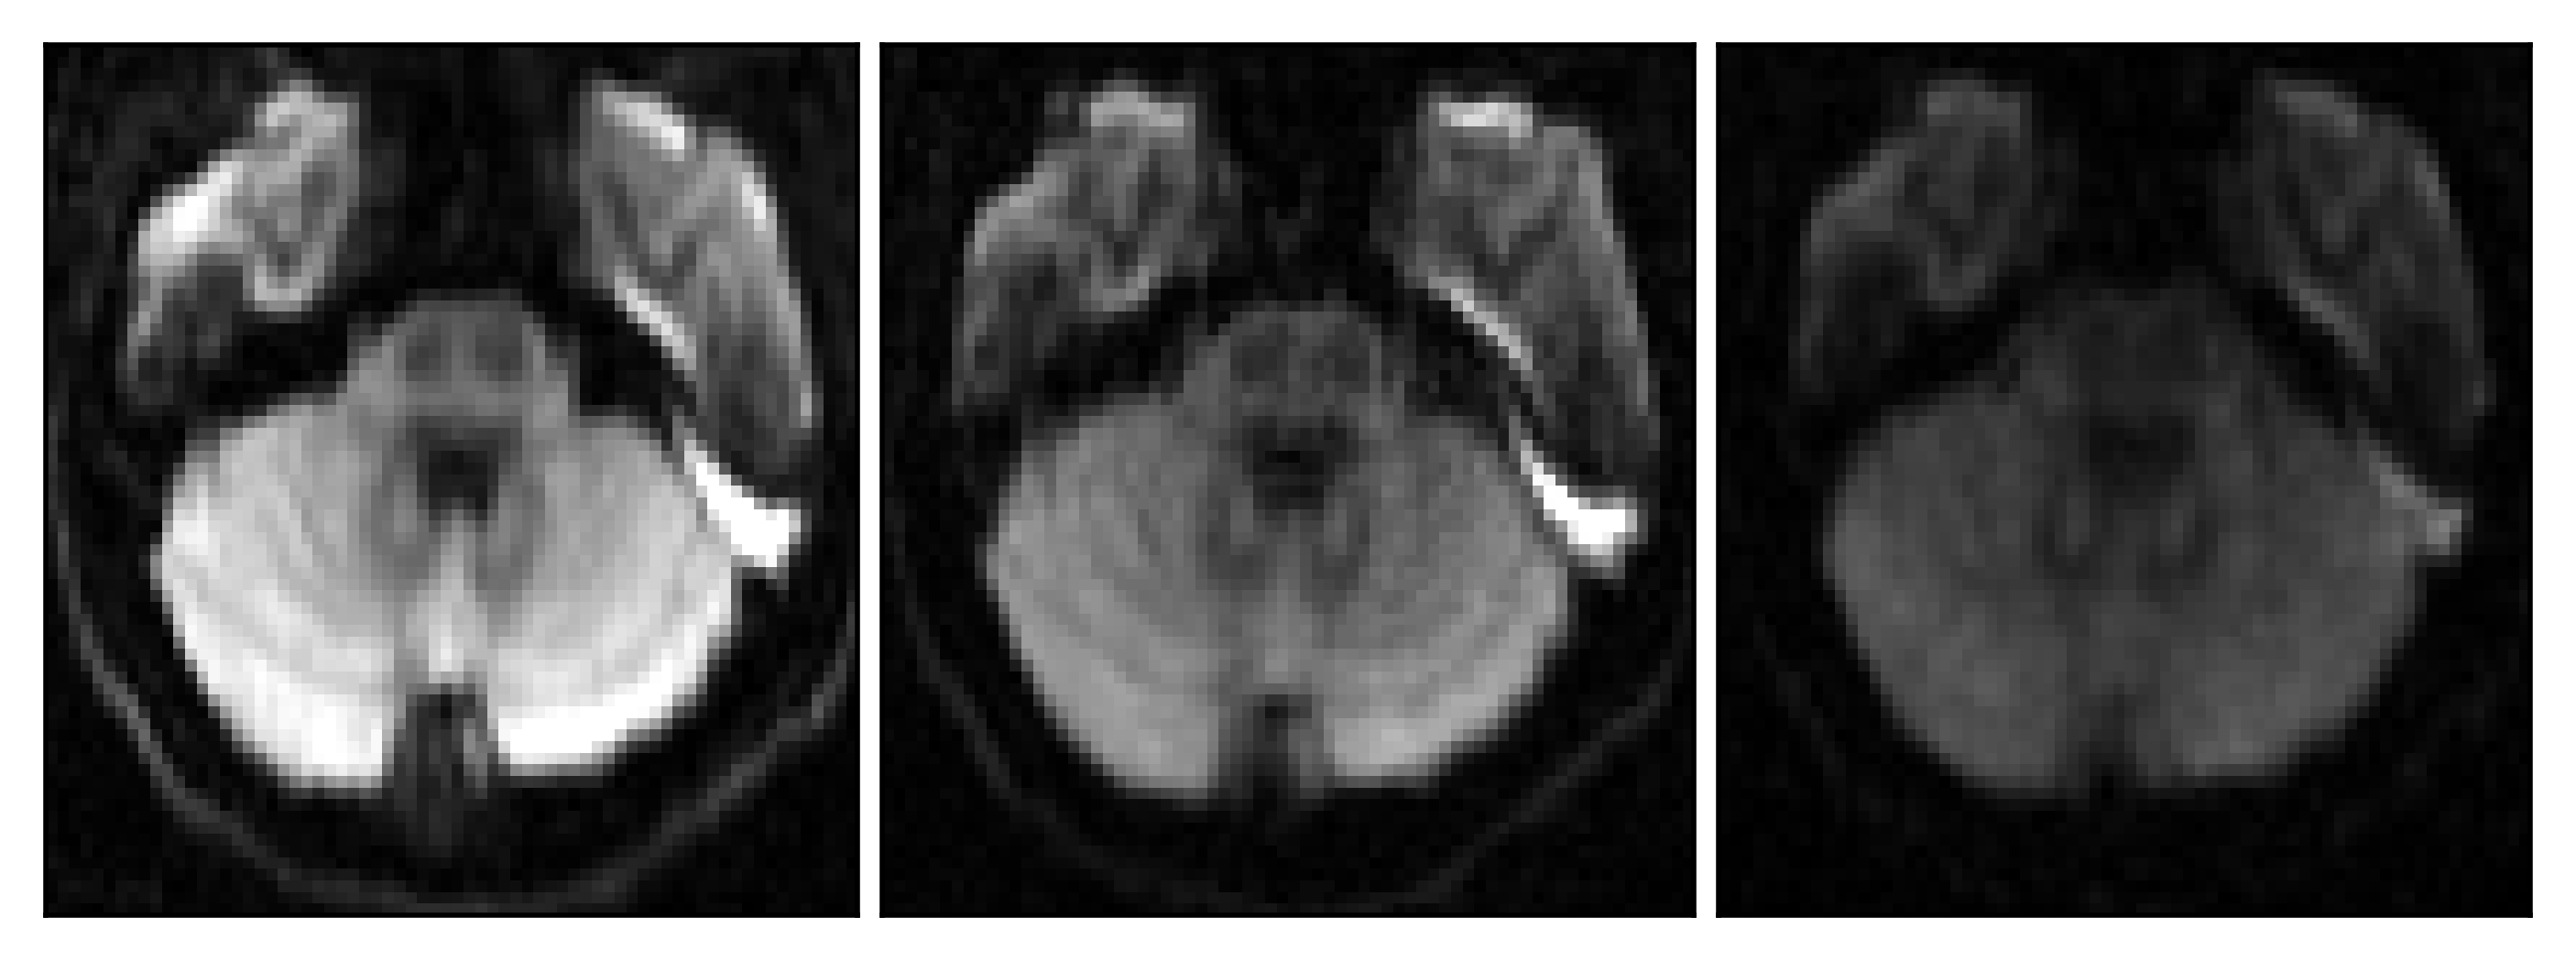

In [15]:
# Image of magnitude 
print('TD',td, 'Volunteer',vv,'sl',sl)
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(7,5), dpi=500)

w1 = 35
w2 = 110
l1= 30
l2 = 100

### Get magnitude images
for ii in range(1):
    axes[0].imshow(abs(M0_mag)[w1:w2,l1:l2,sl,diffusion,rep,td],vmin = 0,vmax = 400,cmap = 'gray',interpolation = 'nearest')
    axes[1].imshow(abs(M1_mag)[w1:w2,l1:l2,sl,diffusion,rep,td],vmin = 0,vmax = 400,cmap = 'gray',interpolation = 'nearest')
    im0=axes[2].imshow(abs(M2_mag)[w1:w2,l1:l2,sl,diffusion,rep,td],vmin = 0,vmax = 400,cmap = 'gray',interpolation = 'nearest')


for j in range(3):
    axes[ j].get_xaxis().set_ticks([])
    axes[ j].get_yaxis().set_ticks([])

plt.subplots_adjust(wspace=0.03, hspace=0.03)  
plt.show()